In [1]:
if sc:
    sc.stop()

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("22125094_lab6")
sc = SparkContext(conf = conf)

sc.getConf().getAll()

[('spark.app.submitTime', '1765458003968'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.port', '33537'),
 ('spark.org.apache.hadoop

In [3]:
retail_data = sc.textFile("hdfs://name:9000/Lab6_Datasets/online_retail.csv")

header = retail_data.first()
retail_data = retail_data.filter(lambda x : x != header)
retail_data = retail_data.map(lambda x : x.split(","))  

retail_data.collect()

[['0',
  '536365',
  '85123A',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  '6',
  '12/1/2010 8:26',
  '2.55',
  '17850.0',
  'United Kingdom'],
 ['1',
  '536365',
  '71053',
  'WHITE METAL LANTERN',
  '6',
  '12/1/2010 8:26',
  '3.39',
  '17850.0',
  'United Kingdom'],
 ['2',
  '536365',
  '84406B',
  'CREAM CUPID HEARTS COAT HANGER',
  '8',
  '12/1/2010 8:26',
  '2.75',
  '17850.0',
  'United Kingdom'],
 ['3',
  '536365',
  '84029G',
  'KNITTED UNION FLAG HOT WATER BOTTLE',
  '6',
  '12/1/2010 8:26',
  '3.39',
  '17850.0',
  'United Kingdom'],
 ['4',
  '536365',
  '84029E',
  'RED WOOLLY HOTTIE WHITE HEART.',
  '6',
  '12/1/2010 8:26',
  '3.39',
  '17850.0',
  'United Kingdom'],
 ['5',
  '536365',
  '22752',
  'SET 7 BABUSHKA NESTING BOXES',
  '2',
  '12/1/2010 8:26',
  '7.65',
  '17850.0',
  'United Kingdom'],
 ['6',
  '536365',
  '21730',
  'GLASS STAR FROSTED T-LIGHT HOLDER',
  '6',
  '12/1/2010 8:26',
  '4.25',
  '17850.0',
  'United Kingdom'],
 ['7',
  '536366',
  '22633',
  'HAND 

In [4]:
def parse_row(x):
    try:
        for i in x:
            if i == "":
                return None
        return (
            int(x[0]),
            x[1],
            x[2],
            x[3],
            int(x[4]),
            x[5],
            float(x[6]),
            x[7],
            x[8]
        )
    except:
        return None

retail_parsed = retail_data.map(parse_row).filter(lambda x: x is not None)
retail_parsed.count()

403722

In [5]:
rfm = retail_parsed.map(lambda x: (x[7], x[1], x[5], x[4] * x[6]))
rfm.take(5)

[('17850.0', '536365', '12/1/2010 8:26', 15.299999999999999),
 ('17850.0', '536365', '12/1/2010 8:26', 20.34),
 ('17850.0', '536365', '12/1/2010 8:26', 22.0),
 ('17850.0', '536365', '12/1/2010 8:26', 20.34),
 ('17850.0', '536365', '12/1/2010 8:26', 20.34)]

In [6]:
from datetime import datetime

def parse_date(x):
    cus_id, inv_no, inv_date, total = x
    inv_dt = datetime.strptime(inv_date, "%m/%d/%Y %H:%M")
    return (cus_id, inv_no, inv_dt, total)

rfm = rfm.map(parse_date)
rfm.take(5)

[('17850.0',
  '536365',
  datetime.datetime(2010, 12, 1, 8, 26),
  15.299999999999999),
 ('17850.0', '536365', datetime.datetime(2010, 12, 1, 8, 26), 20.34),
 ('17850.0', '536365', datetime.datetime(2010, 12, 1, 8, 26), 22.0),
 ('17850.0', '536365', datetime.datetime(2010, 12, 1, 8, 26), 20.34),
 ('17850.0', '536365', datetime.datetime(2010, 12, 1, 8, 26), 20.34)]

Compute RFM

In [7]:
last_buy = rfm.map(lambda x: (x[0], x[2])).reduceByKey(lambda a, b : max(a, b))
latest = last_buy.map(lambda x: x[1]).max()
last_buy.take(5)


[('13098.0', datetime.datetime(2011, 12, 8, 14, 14)),
 ('14410.0', datetime.datetime(2011, 11, 24, 11, 16)),
 ('14403.0', datetime.datetime(2011, 8, 1, 12, 57)),
 ('13668.0', datetime.datetime(2011, 12, 7, 12, 14)),
 ('14085.0', datetime.datetime(2011, 12, 7, 13, 46))]

In [8]:
recency = last_buy.map(lambda x: (x[0], (latest - x[1]).days))
recency.take(5)


[('13047.0', 31),
 ('15291.0', 25),
 ('14688.0', 7),
 ('17809.0', 15),
 ('16098.0', 87)]

In [9]:
frequency = rfm.map(lambda x: (x[0], x[1])).distinct()
frequency = frequency.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b : a + b)
frequency.take(5)

[('13098.0', 41),
 ('13668.0', 29),
 ('14085.0', 19),
 ('14410.0', 15),
 ('14866.0', 13)]

In [10]:
monetary = rfm.map(lambda x: (x[0], x[3])).reduceByKey(lambda a, b : a + b)
monetary.take(5)

[('13047.0', 2985.5),
 ('15291.0', 4596.51),
 ('14688.0', 4932.840000000001),
 ('17809.0', 4378.619999999999),
 ('16098.0', 2005.63)]

In [11]:
rfm_rdd = recency.join(frequency).join(monetary)
rfm_rdd.take(5)

[('12791.0', ((373, 1), 192.60000000000002)),
 ('14849.0', ((21, 28), 7904.279999999997)),
 ('16928.0', ((79, 19), 2781.500000000001)),
 ('12947.0', ((143, 11), 1396.79)),
 ('17069.0', ((27, 13), 2641.5699999999993))]

In [12]:
rfm_final = rfm_rdd.map(lambda x: (float(x[1][0][0]), float(x[1][0][1]), float(x[1][1]))).collect()
rfm_final

[(15.0, 15.0, 572.0999999999996),
 (1.0, 19.0, 4415.629999999998),
 (81.0, 3.0, 1799.3299999999995),
 (39.0, 11.0, 2741.080000000001),
 (3.0, 89.0, 10930.259999999998),
 (43.0, 5.0, 1430.9400000000003),
 (31.0, 3.0, 566.5799999999999),
 (19.0, 24.0, 6945.019999999999),
 (22.0, 3.0, 953.6200000000003),
 (34.0, 3.0, 798.7399999999999),
 (0.0, 23.0, 2556.68),
 (36.0, 7.0, 1727.8200000000002),
 (91.0, 7.0, 852.12),
 (38.0, 76.0, 50992.609999999964),
 (136.0, 5.0, 712.2399999999998),
 (3.0, 18.0, 1834.55),
 (54.0, 3.0, 383.67999999999995),
 (135.0, 1.0, 60.7),
 (24.0, 11.0, 1534.6699999999998),
 (32.0, 5.0, 1698.94),
 (29.0, 6.0, 2183.04),
 (9.0, 18.0, 2058.0900000000006),
 (116.0, 4.0, 588.1299999999999),
 (17.0, 7.0, 2298.930000000001),
 (2.0, 5.0, 757.48),
 (11.0, 9.0, 2978.859999999998),
 (14.0, 14.0, 4386.110000000002),
 (39.0, 4.0, 646.9199999999998),
 (22.0, 5.0, 732.0699999999998),
 (26.0, 14.0, 1965.5499999999993),
 (16.0, 7.0, 1839.0700000000002),
 (63.0, 7.0, 2494.4599999999996),

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler

rfm_array = np.array(rfm_final)

scaler = StandardScaler()
X = scaler.fit_transform(rfm_array)
X

array([[-0.75536054,  1.06406227, -0.1609506 ],
       [-0.89441086,  1.49277746,  0.30825616],
       [-0.09983759, -0.2220833 , -0.011134  ],
       ...,
       [ 0.58548186, -0.3292621 , -0.19704634],
       [ 0.62521053, -0.43644089, -0.19312035],
       [ 0.52588887, -0.43644089, -0.21215216]])

# CURE

In this problem, the dataset is large, so we need some enhancements from the authors' of CURE to make it work on large datasets. 

For large datasets, CURE algorithm is a bit different from "pure" version of it. We will call it Scalable CURE. In Scalable CURE, there are enhancements, not in the algorithm itself, but in the data  input. Instead of clustering all data, it is done in 4 steps before running the algorithm: 
- Step 1: Random sampling. Instead of clustering all data, take a random sample 𝑠 (e.g., 2% of dataset). Then, run CURE only on this sample. 
- Step 2: Paritioning. Split into 𝑝 partitions (e.g., 50000 points if splited into 10 partitions, each will have 5000 points). For each partition, run CURE to get local clusters, and extract representative points, then combine all representatives and cluster them again. 
- Step 3: Labeling. After CURE clusters sampled data, take all remaining unsampled points and assigned each to nearest cluster using representative points.

According to the authors’ of CURE algorithm, working on large datasets, they found out that: 
- Shrink factor 𝛼: Best in range 0.2 – 0.7. If leq than 0.1, merges wrong clusters, behaves like MST. If geq 0.8 and leq 1.0, behaves like traditional centroid-based clustering. In the paper, their default value is 0.3.  
- Number of representative points 𝑐: With value geq 10, CURE always find out right clusters. If less than 10, it might easily merge wrong clusters, forming bad clusters. Best if in range 10 to 20. 
- Sample size 𝑠: Good sample size should be around 2 – 3% of dataset. 
- Number of partitions 𝑝: Should be 2 – 3 times the number of true clusters.  

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

sc.addPyFile("hdfs:///Lab6_Datasets/cure.py")


In [22]:
ratio = 0.2
np.random.seed(42)
sample_idx = np.random.choice(len(X), size=int(len(X) * ratio), replace=False)
sample = X[sample_idx]
rest = np.delete(X, sample_idx, axis=0)

## Elbow method

In this step, I am confused because Elbow method is for KMeans clustering algorithm, I have see no information about using it for BFR or CURE. Therefore, I implement a simple KMeans and let it run on datasets to get the elbow point for using in CURE algorithm.

In [23]:
def kmeans(data, k, max_iter=100):
    indices = np.random.choice(len(data), k, replace=False)
    centroids = data[indices]
    labels = np.zeros(len(data), dtype=int)

    for _ in range(max_iter):
        # assign each points to the nearest cluster
        new_labels = np.zeros(len(data), dtype=int)
        for i in range(len(data)):
            best_dist = float("inf")
            best_cluster = -1
            for j in range(k):
                dist = np.linalg.norm(data[i] - centroids[j])
                if dist < best_dist:
                    best_dist = dist
                    best_cluster = j
            new_labels[i] = best_cluster
        # update centroids
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            points = []
            for i in range(len(data)):
                if new_labels[i] == j:
                    points.append(data[i])
            if len(points) > 0:
                new_centroids[j] = np.mean(points, axis=0)
            else:
                new_centroids[j] = centroids[j]
        labels = new_labels
        # convergence check
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, labels

In [24]:
def compute_wcss(data, centroids, labels):
    wcss = 0.0
    for i in range(len(data)):
        diff = data[i] - centroids[labels[i]]
        wcss += np.dot(diff, diff)
    return wcss

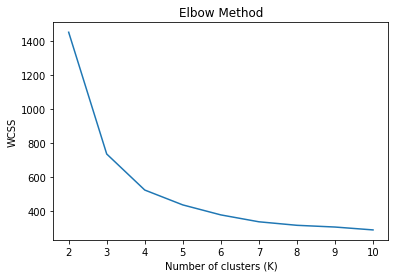

In [25]:
ks = range(2, 11)
wcss_values = []

for k in ks:
    centroids, labels = kmeans(sample, k)
    wcss = compute_wcss(sample, centroids, labels)
    wcss_values.append(wcss)

plt.plot(ks, wcss_values)
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [26]:
from cure import CURE

# k is chosen from Elbow method
model = CURE(k = 4, c = 10, alpha = 0.3)
sample_clusters = model.cure(sample)

In [27]:
rep_points = []
rep_labels = []

for cl in sample_clusters:
    for rep in cl.reps:
        rep_points.append(rep)
        rep_labels.append(cl.id)

rep_points = np.array(rep_points)
rep_labels = np.array(rep_labels)

In [28]:
sample_labels = np.empty(len(sample), dtype=int)

for cl in sample_clusters:
    for idx in cl.points_idx:
        sample_labels[idx] = cl.id

In [29]:
from sklearn.metrics import pairwise_distances_argmin_min
nearest_rep_idx, _ = pairwise_distances_argmin_min(rest, rep_points)
rest_labels = rep_labels[nearest_rep_idx]

In [30]:
full_labels = np.empty(len(X), dtype=int)

full_labels[sample_idx] = sample_labels

rest_idx = np.setdiff1d(np.arange(len(X)), sample_idx)
full_labels[rest_idx] = rest_labels

In [31]:
unique, counts = np.unique(full_labels, return_counts=True)
full_cluster_sizes = dict(zip(unique, counts))
print(full_cluster_sizes)

{242: 3, 482: 6, 844: 4, 1743: 4357}


In [34]:
df = pd.DataFrame(X, columns=['R', 'F', 'M'])
df['cluster'] = full_labels

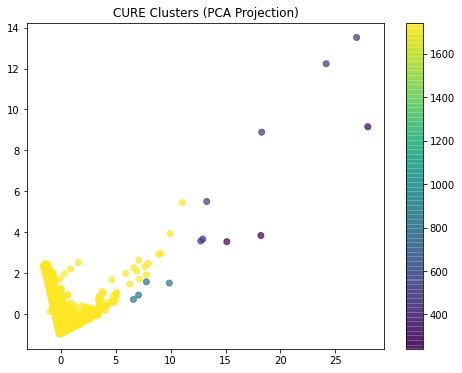

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(X)
df['pca1'] = reduced[:, 0]
df['pca2'] = reduced[:, 1]

plt.figure(figsize=(8,6))
plt.scatter(df['pca1'], df['pca2'], c=df['cluster'], alpha=0.7)
plt.colorbar()
plt.title("CURE Clusters (PCA Projection)")
plt.show()